## 1) Import libraries and define file paths


In [1]:
import os, sys
print("CWD =", os.getcwd())

CWD = /Users/wujiamin/weather-trend-forecasting/notebooks


In [2]:

import pandas as pd      
import numpy as np       
from pathlib import Path 

RAW = Path("../data/GlobalWeatherRepository.csv")   # Location of your raw CSV
CLEAN = Path("../data/cleaned_weather.csv")           # Where the cleaned file will be saved

# Safety check: stop early if the file is missing
assert RAW.exists(), f"Raw CSV not found: {RAW}. Please place the Kaggle file in the data/ folder."
print("Raw CSV path:", RAW.resolve())


Raw CSV path: /Users/wujiamin/weather-trend-forecasting/data/GlobalWeatherRepository.csv


## 2) Quick peek at the data (first 5 rows)


In [3]:
import pandas as pd
sample = pd.read_csv(RAW, nrows=5, low_memory=False)  # Load only 5 rows to preview
display(sample.head())                                 # Show the first 5 rows
print("Columns (first 20):", list(sample.columns)[:20], "...")  # Show some column names


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


Columns (first 20): ['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud'] ...


## 3) Load the full dataset 


In [4]:

df = pd.read_csv(RAW, low_memory=False)  # Load all rows
print("Shape (rows, cols):", df.shape)   # Show dataset dimensions


Shape (rows, cols): (90612, 41)


## 4) Normalize column names and parse the timestamp


In [5]:

# 1) Normalize column names: trim spaces, lowercase, replace spaces with underscores
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 2) Try multiple possible time column names
dt_candidates = ["lastupdated","last_updated","lastupdate","timestamp","date","datetime"]
dt_col = next((c for c in dt_candidates if c in df.columns), None)
assert dt_col, f"No datetime column found. Tried: {dt_candidates}"

# 3) Parse to pandas datetime in UTC; invalid parses become NaT (missing)
df["timestamp"] = pd.to_datetime(df[dt_col], errors="coerce", utc=True)

# 4) Drop rows with invalid/missing timestamps
before = len(df)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
after = len(df)
print(f"Dropped {before - after} rows with invalid timestamps.")
df[["timestamp"]].head()


Dropped 0 rows with invalid timestamps.


,timestamp
186,2024-05-16 01:45:00+00:00
40,2024-05-16 02:45:00+00:00
74,2024-05-16 02:45:00+00:00
124,2024-05-16 02:45:00+00:00
17,2024-05-16 02:45:00+00:00


## 5) Handle missing values (NaNs)

**Strategy:**
- For **numeric columns**: fill with the **median** (robust to outliers).
- For **categorical/text columns**: fill with the **mode** (most frequent value).



In [13]:

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns            # numeric columns like temperature, precipitation, etc.
cat_cols = [c for c in df.columns if c not in num_cols]             # non-numeric columns like city, country

# Fill numeric NaNs with the median of that column
for c in num_cols:
    if df[c].isna().any():
        print(f"Filling numeric column {c} with median")
        df[c] = df[c].fillna(df[c].median())

# Fill categorical NaNs with the most frequent value (mode) of that column
for c in cat_cols:
    if df[c].isna().any():
        mode = df[c].mode()
        if not mode.empty:
            print(f"Filling categorical column {c} with mode = {mode.iloc[0]}")
            df[c] = df[c].fillna(mode.iloc[0])


## 6) Reduce the impact of extreme outliers

**Clip** extreme values to a safe range (between the 1st and 99th percentile).  
This keeps unusual spikes from dominating your analysis, while still keeping the row.



In [14]:

for c in num_cols:
    q1, q99 = df[c].quantile([0.01, 0.99])  # 1st and 99th percentiles
    df[c] = df[c].clip(lower=q1, upper=q99) # Clip extreme values


## 7) Aggregate to **daily** level (optionally per city/country)

dataset may have multiple records inside the same day.  
will:
1. Create a `date` column from `timestamp`.
2. Define **grouping keys**: always `date`, plus `city`/`country` if those columns exist.
3. Group and compute the **mean** for numeric columns.



In [15]:

# 1) Create a pure date column
df["date"] = df["timestamp"].dt.date

# 2) Build grouping keys
group_keys = ["date"]
if "city" in df.columns: group_keys.append("city")
if "country" in df.columns: group_keys.append("country")

# 3) Group and average numeric values
df_daily = df.groupby(group_keys).mean(numeric_only=True).reset_index()

# Recreate a timestamp column (midnight of that day)
import pandas as pd
df_daily["timestamp"] = pd.to_datetime(df_daily["date"])  # converts 'date' back to a datetime
df_daily = df_daily.drop(columns=["date"])

print("Daily shape:", df_daily.shape)
df_daily.head()


Daily shape: (85745, 32)


,country,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,...,air_quality_carbon_monoxide,air_quality_ozone,air_quality_nitrogen_dioxide,air_quality_sulphur_dioxide,air_quality_pm2.5,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination,timestamp
0,Afghanistan,34.52,69.18,1.716128e+09,24.3,75.7,6.40,10.25,328.0,1013.0,...,886.20,81.55,10.25,0.40,8.9000,22.75,1.0,1.0,55.0,2024-05-16
1,Albania,41.33,19.82,1.716128e+09,24.0,75.2,5.60,9.00,275.0,1010.0,...,194.45,95.15,2.25,0.20,1.7000,3.15,1.0,1.0,55.0,2024-05-16
2,Algeria,36.76,3.05,1.716128e+09,24.0,75.2,13.40,21.60,305.0,1010.5,...,369.65,59.05,33.45,7.70,7.3500,14.95,1.0,1.0,55.0,2024-05-16
3,Andorra,42.50,1.52,1.716128e+09,6.3,43.3,6.85,11.00,219.0,1007.0,...,163.55,72.25,1.15,0.15,0.7000,0.90,1.0,1.0,55.0,2024-05-16
4,Angola,-8.84,13.23,1.716128e+09,29.0,84.2,12.10,19.45,215.0,1009.5,...,1729.00,52.40,40.85,17.75,104.5575,165.40,3.5,6.5,55.0,2024-05-16


## 8)  Aggregate to **daily** level (by country)

- 1.Create a `date` from `timestamp`.  
- 2.Group by `date` and `country`.  
- 3.Average numeric columns (daily aggregates).  
- 4.Rebuild a `timestamp` at midnight for plotting convenience.


In [19]:
print(df_daily.columns.tolist())

['country', 'latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide', 'air_quality_ozone', 'air_quality_nitrogen_dioxide', 'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination', 'timestamp']


In [18]:
# --- use actual columns ---
assert "timestamp" in df.columns, "timestamp column missing after earlier steps."
assert "country" in df.columns, "country column is required for country-level aggregation."

# Make a date column
df["date"] = df["timestamp"].dt.date

# Group by date + country and average numeric columns
df_daily = (
    df.groupby(["date", "country"], as_index=False)
      .mean(numeric_only=True)
)

# Recreate a midnight timestamp from date
import pandas as pd
df_daily["timestamp"] = pd.to_datetime(df_daily["date"])
df_daily = df_daily.drop(columns=["date"])

print("Daily dataset shape:", df_daily.shape)
df_daily.head()


Daily dataset shape: (85745, 32)


,country,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,...,air_quality_carbon_monoxide,air_quality_ozone,air_quality_nitrogen_dioxide,air_quality_sulphur_dioxide,air_quality_pm2.5,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination,timestamp
0,Afghanistan,34.52,69.18,1.716128e+09,24.3,75.7,6.40,10.25,328.0,1013.0,...,886.20,81.55,10.25,0.40,8.9000,22.75,1.0,1.0,55.0,2024-05-16
1,Albania,41.33,19.82,1.716128e+09,24.0,75.2,5.60,9.00,275.0,1010.0,...,194.45,95.15,2.25,0.20,1.7000,3.15,1.0,1.0,55.0,2024-05-16
2,Algeria,36.76,3.05,1.716128e+09,24.0,75.2,13.40,21.60,305.0,1010.5,...,369.65,59.05,33.45,7.70,7.3500,14.95,1.0,1.0,55.0,2024-05-16
3,Andorra,42.50,1.52,1.716128e+09,6.3,43.3,6.85,11.00,219.0,1007.0,...,163.55,72.25,1.15,0.15,0.7000,0.90,1.0,1.0,55.0,2024-05-16
4,Angola,-8.84,13.23,1.716128e+09,29.0,84.2,12.10,19.45,215.0,1009.5,...,1729.00,52.40,40.85,17.75,104.5575,165.40,3.5,6.5,55.0,2024-05-16


['country', 'latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_carbon_monoxide', 'air_quality_ozone', 'air_quality_nitrogen_dioxide', 'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination', 'timestamp']


## Column selection for plotting

- `temperature_celsius` for temperature
-  `precip_mm` for precipitation


In [20]:
# Pick actual column names present in your data
temp_col   = "temperature_celsius"
precip_col = "precip_mm"

# Sanity checks
for col in [temp_col, "country", "timestamp"]:
    assert col in df_daily.columns, f"Missing column in df_daily: {col}"
print("Plot columns OK:", temp_col, "(and precip:", ("present" if precip_col in df_daily.columns else "missing"), ")")

Plot columns OK: temperature_celsius (and precip: present )


## 9) Global daily trends (temperature & precipitation)

average across **all countries** for each day and plot:
- Global daily **temperature** trend  
- Global daily **precipitation** trend

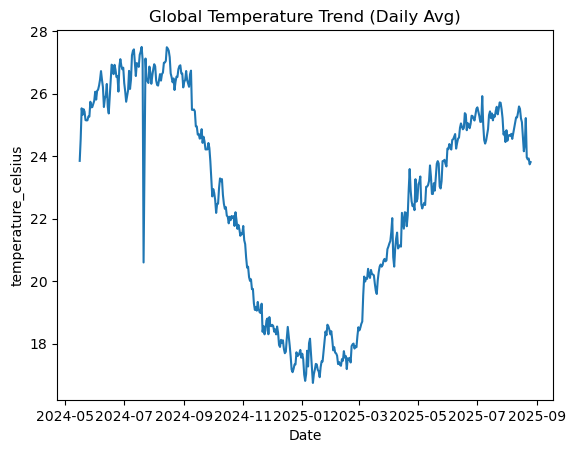

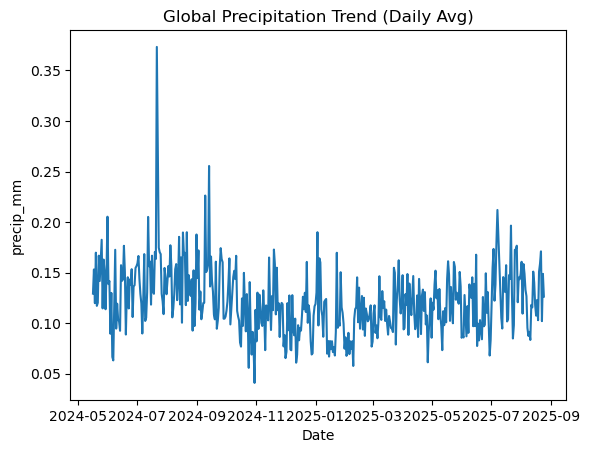

In [21]:
import matplotlib.pyplot as plt

# Average across countries for each day
global_daily = (
    df_daily.groupby("timestamp", as_index=False)
            .mean(numeric_only=True)
)

# Global temperature trend
plt.figure()
plt.plot(global_daily["timestamp"], global_daily[temp_col])
plt.title("Global Temperature Trend (Daily Avg)")
plt.xlabel("Date")
plt.ylabel(temp_col)
plt.show()

# Global precipitation trend (if available)
if precip_col in global_daily.columns:
    plt.figure()
    plt.plot(global_daily["timestamp"], global_daily[precip_col])
    plt.title("Global Precipitation Trend (Daily Avg)")
    plt.xlabel("Date")
    plt.ylabel(precip_col)
    plt.show()
else:
    print("No precipitation column found in global_daily; skipping precipitation plot.")

## 10) Country-level trends

Will:
1) Pick the **most frequent** country (data-rich) and plot its temperature & precipitation trends.  
2) (Optional) Plot **Top 5 countries** on the same temperature chart for comparison.

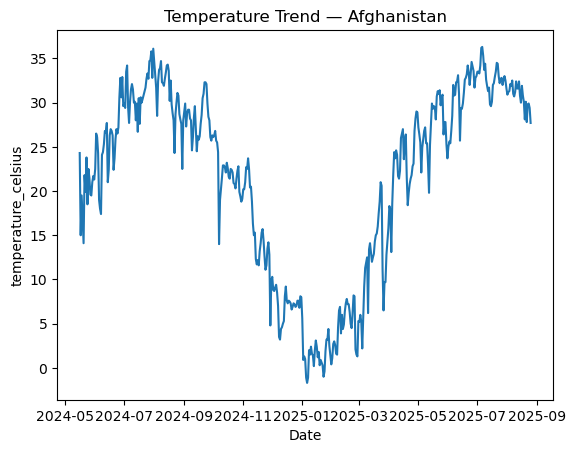

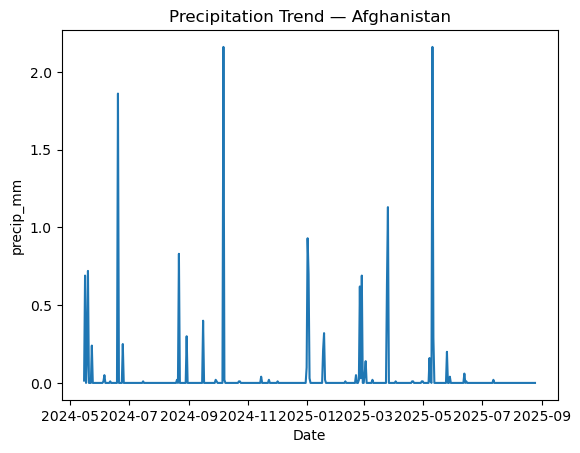

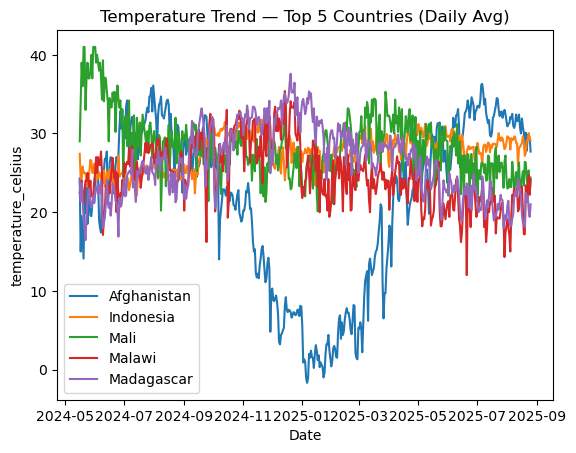

In [22]:
# 1) Most frequent country
top_country = df_daily["country"].value_counts().index[0]
sub = df_daily[df_daily["country"] == top_country].sort_values("timestamp")

# Temperature trend for the top country
plt.figure()
plt.plot(sub["timestamp"], sub[temp_col])
plt.title(f"Temperature Trend — {top_country}")
plt.xlabel("Date")
plt.ylabel(temp_col)
plt.show()

# Precipitation trend for the top country (if available)
if precip_col in sub.columns:
    plt.figure()
    plt.plot(sub["timestamp"], sub[precip_col])
    plt.title(f"Precipitation Trend — {top_country}")
    plt.xlabel("Date")
    plt.ylabel(precip_col)
    plt.show()
else:
    print("No precipitation column in df_daily for plotting at the country level.")

# 2) Compare temperature across Top 5 countries
top_countries = df_daily["country"].value_counts().index[:5]
plt.figure()
for ctry in top_countries:
    sub_ctry = df_daily[df_daily["country"] == ctry].sort_values("timestamp")
    if temp_col in sub_ctry.columns:
        plt.plot(sub_ctry["timestamp"], sub_ctry[temp_col], label=ctry)
plt.title("Temperature Trend — Top 5 Countries (Daily Avg)")
plt.xlabel("Date")
plt.ylabel(temp_col)
plt.legend()
plt.show()

## 11) Save the cleaned dataset

save the result to `data/cleaned_weather.csv`.  
This file will be used by EDA and forecasting notebooks.


In [24]:
from pathlib import Path
CLEAN = Path("../data/cleaned_weather.csv") if "notebooks" in str(Path.cwd()) else Path("data/cleaned_weather.csv")
CLEAN.parent.mkdir(parents=True, exist_ok=True)
df_daily.to_csv(CLEAN, index=False)
print("Saved cleaned dataset to:", CLEAN.resolve())

Saved cleaned dataset to: /Users/wujiamin/weather-trend-forecasting/data/cleaned_weather.csv
